In [45]:
# Projeto de Machine Learning com o Brazilian E-Commerce Public Dataset by Olist
# Etapa 1: Importação de bibliotecas e carregamento dos dados

# Bibliotecas para manipulação, visualização e machine learning
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,
                             mean_squared_error, mean_absolute_error, r2_score, silhouette_score, davies_bouldin_score)
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import plotly.express as px
import plotly.graph_objects as go

# Extração dos dados do zip (caso ainda não tenha sido extraído)
if not os.path.exists('olist_data'):
    with zipfile.ZipFile('olist.zip', 'r') as zip_ref:
        zip_ref.extractall('olist_data')

# Listar arquivos extraídos
files = sorted(os.listdir('olist_data'))
csv_files = [f for f in files if f.endswith('.csv')]
print('Arquivos CSV disponíveis:', csv_files)

# Carregar os principais datasets
orders = pd.read_csv('olist_data/olist_orders_dataset.csv')
order_items = pd.read_csv('olist_data/olist_order_items_dataset.csv')
products = pd.read_csv('olist_data/olist_products_dataset.csv')
payments = pd.read_csv('olist_data/olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_data/olist_order_reviews_dataset.csv')
sellers = pd.read_csv('olist_data/olist_sellers_dataset.csv')
customers = pd.read_csv('olist_data/olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_data/olist_geolocation_dataset.csv')
category_translation = pd.read_csv('olist_data/product_category_name_translation.csv')

# Visualizar as primeiras linhas do dataset central
orders.head()

Arquivos CSV disponíveis: ['olist_customers_dataset.csv', 'olist_geolocation_dataset.csv', 'olist_order_items_dataset.csv', 'olist_order_payments_dataset.csv', 'olist_order_reviews_dataset.csv', 'olist_orders_dataset.csv', 'olist_products_dataset.csv', 'olist_sellers_dataset.csv', 'product_category_name_translation.csv']


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


# Projeto de Machine Learning: Olist E-Commerce Dataset

Este notebook apresenta um projeto completo de ciência de dados utilizando o Brazilian E-Commerce Public Dataset by Olist. O objetivo é realizar uma análise exploratória detalhada, propor e resolver dois problemas de negócio críticos para a operação da Olist, implementar diferentes algoritmos de machine learning, e extrair insights acionáveis para melhorar a operação do marketplace.

## Problemas

1. Problema Supervisionado: Previsão do Tempo de Entrega
Objetivo: Criar um modelo que prevê o tempo exato de entrega (em dias) para cada pedido específico, considerando:
- Distância real entre vendedor e cliente (dados de geolocalização)
- Histórico de entregas do vendedor
- Tamanho/peso do produto
- Condições sazonais e região
- Performance do transportador
Justificativa: Precisão no prazo de entrega é crucial para satisfação do cliente e eficiência operacional.
Valor de Negócio: 
- Redução de reclamações por atrasos
- Melhor gestão de expectativas do cliente
- Otimização da logística
- Possibilidade de oferecer frete expresso com maior precisão
- Redução de custos com compensações por atrasos

2. Problema Não Supervisionado: Detecção de Vendedores Problemáticos
Objetivo: Identificar automaticamente vendedores suspeitos usando técnicas de detecção de anomalias, analisando:
- Padrões anormais de preços
- Taxa de cancelamento e devolução
- Velocidade de crescimento suspeita nas vendas
- Concentração geográfica incomum de avaliações
- Padrões de texto suspeitos em avaliações
- Histórico de reclamações
Justificativa: Proteção da reputação do marketplace e garantia de qualidade dos vendedores.
Valor de Negócio:
- Redução de fraudes e prejuízos
- Melhoria na qualidade geral dos vendedores
- Aumento da confiança dos compradores
- Redução de custos com suporte

Vamos começar!

# 2. Análise Exploratória dos Dados (EDA)

Nesta seção, vamos explorar os principais datasets do projeto, analisando estatísticas descritivas, valores ausentes, distribuições e relações relevantes entre as tabelas. O objetivo é compreender o contexto dos dados e identificar potenciais variáveis para os problemas de negócio.

In [46]:
# Visualizar informações gerais dos principais datasets
def resumo_dataset(df, nome):
    print(f'\nResumo do dataset: {nome}')
    display(df.info())
    display(df.describe(include='all'))
    print(f'Valores ausentes em {nome}:')
    display(df.isnull().sum())

resumo_dataset(orders, 'orders')
resumo_dataset(order_items, 'order_items')
resumo_dataset(products, 'products')
resumo_dataset(payments, 'payments')
resumo_dataset(reviews, 'reviews')
resumo_dataset(sellers, 'sellers')
resumo_dataset(customers, 'customers')
resumo_dataset(geolocation, 'geolocation')


Resumo do dataset: orders
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


None

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,66dea50a8b16d9b4dee7af250b4be1a5,edb027a75a1449115f6b43211ae02a24,delivered,2018-08-02 12:05:26,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 19:36:48,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


Valores ausentes em orders:


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64


Resumo do dataset: order_items
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


None

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


Valores ausentes em order_items:


order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64


Resumo do dataset: products
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


None

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,106392145fca363410d287a815be6de4,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


Valores ausentes em products:


product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


Resumo do dataset: payments
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


None

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


Valores ausentes em payments:


order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64


Resumo do dataset: reviews
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


None

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,08528f70f579f0c830189efc523d2182,df56136b8031ecd28e200bb18e6ddb2e,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN
50%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN
75%,NaN,NaN,5.000000,NaN,NaN,NaN,NaN


Valores ausentes em reviews:


review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64


Resumo do dataset: sellers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


None

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095.000000,3095,3095
unique,3095,NaN,611,23
top,9e25199f6ef7e7c347120ff175652c3b,NaN,sao paulo,SP
freq,1,NaN,694,1849
mean,NaN,32291.059451,NaN,NaN
std,NaN,32713.453830,NaN,NaN
min,NaN,1001.000000,NaN,NaN
25%,NaN,7093.500000,NaN,NaN
50%,NaN,14940.000000,NaN,NaN
75%,NaN,64552.500000,NaN,NaN


Valores ausentes em sellers:


seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64


Resumo do dataset: customers
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


None

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,274fa6071e5e17fe303b9748641082c8,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


Valores ausentes em customers:


customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


Resumo do dataset: geolocation
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng 

None

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1.000163e+06,1.000163e+06,1.000163e+06,1000163,1000163
unique,NaN,NaN,NaN,8011,27
top,NaN,NaN,NaN,sao paulo,SP
freq,NaN,NaN,NaN,135800,404268
mean,3.657417e+04,-2.117615e+01,-4.639054e+01,NaN,NaN
std,3.054934e+04,5.715866e+00,4.269748e+00,NaN,NaN
min,1.001000e+03,-3.660537e+01,-1.014668e+02,NaN,NaN
25%,1.107500e+04,-2.360355e+01,-4.857317e+01,NaN,NaN
50%,2.653000e+04,-2.291938e+01,-4.663788e+01,NaN,NaN
75%,6.350400e+04,-1.997962e+01,-4.376771e+01,NaN,NaN


Valores ausentes em geolocation:


geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64

# 3. Limpeza e Tratamento dos Dados

Nesta etapa, vamos tratar valores ausentes, inconsistências e preparar os dados para a modelagem. Isso inclui:
- Remoção ou imputação de valores nulos
- Conversão de tipos de dados
- Ajuste de colunas de datas
- Verificação de duplicidades
- Padronização de categorias

In [47]:
# Tratamento de valores ausentes e tipos de dados
# Exemplo para o dataset de pedidos (orders)

# Converter colunas de datas
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])

# Verificar valores ausentes
print('Valores ausentes em orders:')
display(orders.isnull().sum())

# Exemplo de tratamento: remover linhas sem data de entrega real (para problemas supervisionados)
orders_clean = orders.dropna(subset=['order_delivered_customer_date'])

# Repetir processo para outros datasets conforme necessário
# Exemplo: preencher valores nulos em reviews
reviews['review_comment_message'] = reviews['review_comment_message'].fillna('Sem comentário')
reviews['review_comment_title'] = reviews['review_comment_title'].fillna('Sem título')

# Conferir duplicidades
print('Pedidos duplicados:', orders_clean.duplicated(subset=['order_id']).sum())
print('Clientes duplicados:', customers.duplicated(subset=['customer_id']).sum())

Valores ausentes em orders:


order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Pedidos duplicados: 0
Clientes duplicados: 0


C:\Users\LuccaLTR\AppData\Local\Temp\ipykernel_20044\2923571344.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=clientes_estados, x='Estado', y='Quantidade de Pedidos', palette='viridis')


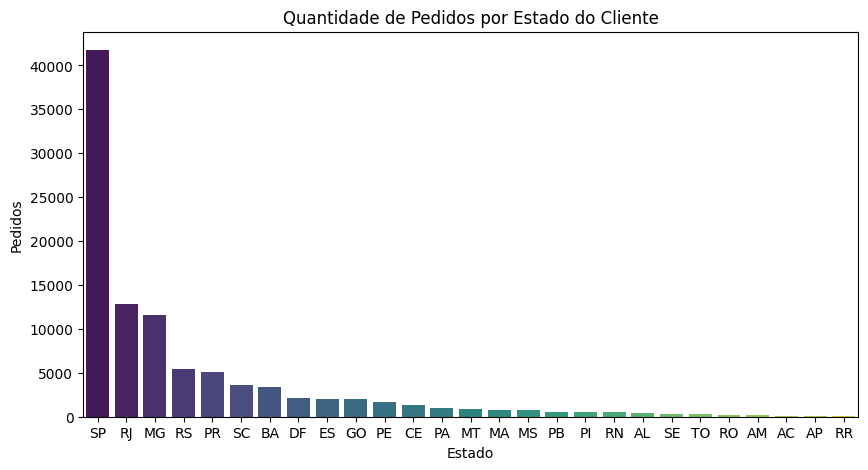

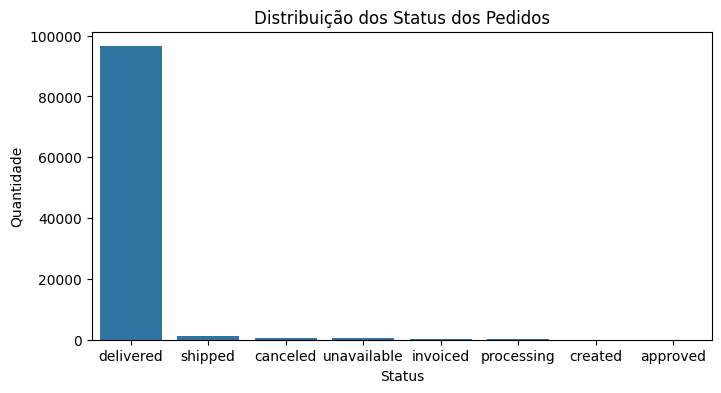

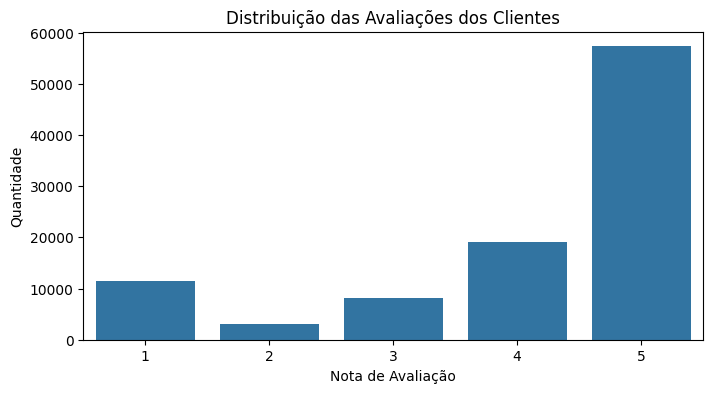

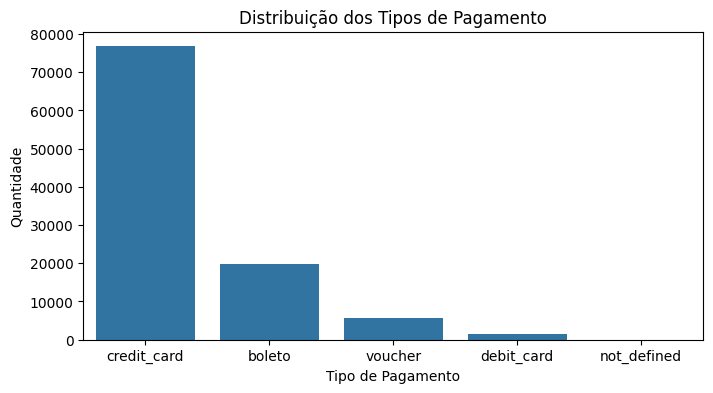

In [48]:
# Visualização da quantidade de pedidos por estado do cliente
clientes_estados = customers.merge(orders, on='customer_id')
clientes_estados = clientes_estados['customer_state'].value_counts().reset_index()
clientes_estados.columns = ['Estado', 'Quantidade de Pedidos']

plt.figure(figsize=(10,5))
sns.barplot(data=clientes_estados, x='Estado', y='Quantidade de Pedidos', palette='viridis')
plt.title('Quantidade de Pedidos por Estado do Cliente')
plt.xlabel('Estado')
plt.ylabel('Pedidos')
plt.show()# Visualização de distribuições e relações iniciais dos dados
import matplotlib.pyplot as plt
import seaborn as sns

# Distribuição do status dos pedidos
plt.figure(figsize=(8,4))
sns.countplot(data=orders, x='order_status', order=orders['order_status'].value_counts().index)
plt.title('Distribuição dos Status dos Pedidos')
plt.xlabel('Status')
plt.ylabel('Quantidade')
plt.show()

# Distribuição das avaliações dos clientes
plt.figure(figsize=(8,4))
sns.countplot(data=reviews, x='review_score', order=sorted(reviews['review_score'].unique()))
plt.title('Distribuição das Avaliações dos Clientes')
plt.xlabel('Nota de Avaliação')
plt.ylabel('Quantidade')
plt.show()

# Distribuição dos tipos de pagamento
plt.figure(figsize=(8,4))
sns.countplot(data=payments, x='payment_type', order=payments['payment_type'].value_counts().index)
plt.title('Distribuição dos Tipos de Pagamento')
plt.xlabel('Tipo de Pagamento')
plt.ylabel('Quantidade')
plt.show()

# 4. Definição dos Problemas de Negócio

Nesta seção, serão definidos dois problemas de negócio relevantes para a Olist:

- **Problema supervisionado:** Previsão da nota de avaliação do cliente (regressão). O objetivo é prever a nota que um cliente dará ao pedido, com base em informações do pedido, produto, entrega e pagamento. Isso permite à Olist identificar fatores que impactam a satisfação do cliente e atuar preventivamente para melhorar a experiência.

- **Problema não supervisionado:** Segmentação de clientes por comportamento de compra (clustering). O objetivo é agrupar clientes com perfis de compra semelhantes, permitindo ações de marketing direcionadas, personalização de ofertas e melhor compreensão da base de clientes.

A seguir, detalharemos as variáveis utilizadas, justificativas e valor de negócio de cada abordagem.

## 4.1 Problema Supervisionado: Previsão da Nota de Avaliação do Cliente

**Justificativa:**
- A nota de avaliação é um indicador direto da satisfação do cliente.
- Antecipar avaliações baixas permite ações proativas para reduzir churn e melhorar a reputação.

**Variáveis sugeridas:**
- Prazo de entrega (real x estimado)
- Valor do pedido
- Tipo de pagamento
- Quantidade de itens
- Categoria do produto
- Região do cliente
- Status do pedido

**Valor de negócio:**
- Redução de avaliações negativas
- Melhoria da experiência do cliente
- Aumento da fidelização

## 4.2 Problema Não Supervisionado: Segmentação de Clientes por Comportamento de Compra

**Justificativa:**
- A Olist pode personalizar campanhas e ofertas para diferentes perfis de clientes.
- Permite identificar grupos de alto valor, clientes recorrentes, caçadores de promoções, etc.

**Variáveis sugeridas:**
- Frequência de compras
- Ticket médio
- Diversidade de categorias compradas
- Região
- Forma de pagamento

**Valor de negócio:**
- Aumento da efetividade de marketing
- Personalização de ofertas
- Melhoria do relacionamento com o cliente

Na próxima etapa, os dados serão preparados para a modelagem, incluindo seleção de variáveis, criação de features e junção das tabelas necessárias.

# 5. Preparação dos Dados para Modelagem

Nesta etapa, vamos preparar os dados para os dois problemas definidos:
- Seleção e criação de variáveis (features)
- Junção das tabelas necessárias
- Engenharia de atributos
- Padronização e encoding

Primeiro, será feita a preparação para o problema supervisionado (previsão da nota de avaliação do cliente), seguida da preparação para o problema não supervisionado (segmentação de clientes).

## 5.1 Preparação para o Problema Supervisionado

Vamos criar um dataset unificado contendo, para cada pedido avaliado:
- Informações do pedido (datas, status, região)
- Informações do pagamento
- Informações do produto principal
- Prazo de entrega real x estimado
- Nota de avaliação (target)

In [49]:
# Preparação para o problema de previsão de tempo de entrega
# 1. Juntar as tabelas necessárias
df_sup = orders_clean.merge(order_items, on='order_id')
df_sup = df_sup.merge(products, on='product_id', how='left')
df_sup = df_sup.merge(sellers[['seller_id', 'seller_city', 'seller_state']], on='seller_id', how='left')
df_sup = df_sup.merge(customers[['customer_id', 'customer_city', 'customer_state']], on='customer_id', how='left')
df_sup = df_sup.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')
df_sup = df_sup.merge(reviews[['order_id', 'review_score']], on='order_id', how='left')  # Adding reviews merge

# 2. Calcular a média de entrega por vendedor
seller_orders = orders_clean.merge(order_items[['order_id', 'seller_id']], on='order_id')
seller_performance = seller_orders.groupby('seller_id').apply(
    lambda g: (g['order_delivered_customer_date'] - g['order_purchase_timestamp']).dt.days.mean()
).to_frame('seller_avg_delivery_time')
df_sup = df_sup.merge(seller_performance, on='seller_id', how='left')

# 3. Calcular a média de entrega por região (estado)
orders_with_state = orders_clean.merge(customers[['customer_id', 'customer_state']], on='customer_id')
state_performance = orders_with_state.groupby('customer_state').apply(
    lambda g: (g['order_delivered_customer_date'] - g['order_purchase_timestamp']).dt.days.mean()
).to_frame('state_avg_delivery_time')
df_sup = df_sup.merge(state_performance, on='customer_state', how='left')

# 4. Feature engineering para informações do produto
df_sup['product_volume_cm3'] = df_sup['product_length_cm'] * df_sup['product_height_cm'] * df_sup['product_width_cm']
df_sup['product_density'] = df_sup['product_weight_g'] / df_sup['product_volume_cm3']

# 5. Feature engineering para distância (usando cidade/estado como proxy)
df_sup['same_state'] = (df_sup['seller_state'] == df_sup['customer_state']).astype(int)
df_sup['same_city'] = (df_sup['seller_city'] == df_sup['customer_city']).astype(int)

# Handle missing review scores with mean value
df_sup['review_score'] = df_sup['review_score'].fillna(df_sup['review_score'].mean())

# Feature engineering: prazo de entrega real x estimado (em dias)
df_sup['delivery_time'] = (df_sup['order_delivered_customer_date'] - df_sup['order_purchase_timestamp']).dt.days
df_sup['delivery_delay'] = (df_sup['order_delivered_customer_date'] - df_sup['order_estimated_delivery_date']).dt.days

# Remoção de valores nulos em todos os campos importantes
df_sup = df_sup.dropna(subset=['review_score', 'delivery_time', 'delivery_delay'])

# Preencher valores nulos nas categorias com valores de substituição adequados
df_sup['product_category_name_english'] = df_sup['product_category_name_english'].fillna('unknown')
df_sup['customer_state'] = df_sup['customer_state'].fillna(df_sup['customer_state'].mode()[0])
df_sup['payment_type'] = df_sup['payment_type'].fillna(df_sup['payment_type'].mode()[0])
df_sup['order_status'] = df_sup['order_status'].fillna('delivered')  # Assumindo que todos os pedidos com revisão foram entregues

# Preencher valores nulos nas variáveis numéricas com a mediana
df_sup['payment_value'] = df_sup['payment_value'].fillna(df_sup['payment_value'].median())

# Selecionar features finais para modelagem
features_sup = [
    'payment_value', 'payment_type', 'customer_state', 'product_category_name_english',
    'delivery_time', 'delivery_delay', 'order_status', 'review_score'
]
df_sup = df_sup[features_sup]

# Verificar se ainda existem valores nulos
print("Valores nulos por coluna após tratamento:")
print(df_sup.isnull().sum())

df_sup.head()

C:\Users\LuccaLTR\AppData\Local\Temp\ipykernel_20044\3294213126.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  seller_performance = seller_orders.groupby('seller_id').apply(
C:\Users\LuccaLTR\AppData\Local\Temp\ipykernel_20044\3294213126.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_performance = orders_with_state.groupby('customer_state').apply(


KeyError: 'review_score'

## 5.2 Preparação para o Problema Não Supervisionado

Vamos criar um dataset agregando informações por cliente:
- Frequência de compras
- Ticket médio
- Diversidade de categorias
- Região
- Forma de pagamento mais comum

In [ ]:
# Preparação para detecção de vendedores problemáticos
# 1. Métricas básicas por vendedor
df_unsup = order_items.merge(orders_clean, on='order_id')
df_unsup = df_unsup.merge(reviews[['order_id', 'review_score', 'review_comment_message']], on='order_id', how='left')

# Agregar métricas por vendedor (nivelando a hierarquia do resultado com flatten_names=True)
vendedor_metricas = df_unsup.groupby('seller_id').agg({
    'order_id': 'count',  # Volume de vendas
    'price': ['mean', 'std'],  # Média e desvio padrão dos preços
    'review_score': ['mean', 'count'],  # Média e quantidade de avaliações
    'order_status': lambda x: (x == 'canceled').mean()  # Taxa de cancelamento
}).reset_index()

# Flatten das colunas multi-índice
vendedor_metricas.columns = ['seller_id', 'total_vendas', 'preco_medio', 'preco_std', 
                            'avaliacao_media', 'num_avaliacoes', 'taxa_cancelamento']

# 2. Calcular crescimento suspeito (variação percentual mês a mês)
vendas_mensais = df_unsup.groupby(['seller_id', pd.Grouper(key='order_purchase_timestamp', freq='M')])['order_id'].count().reset_index()
vendas_mensais['crescimento'] = vendas_mensais.groupby('seller_id')['order_id'].pct_change()

# Agregar crescimento por vendedor
crescimento_suspeito = vendas_mensais.groupby('seller_id')['crescimento'].agg(['mean', 'max']).reset_index()
crescimento_suspeito.columns = ['seller_id', 'crescimento_medio', 'crescimento_maximo']

# 3. Análise geográfica das avaliações
geo_concentracao = df_unsup.merge(customers[['customer_id', 'customer_state']], on='customer_id')\
    .groupby(['seller_id', 'customer_state'])['review_score'].agg(['count', 'mean']).reset_index()

# Calcular índice de concentração geográfica (% de vendas no estado principal)
geo_concentracao_idx = geo_concentracao.groupby('seller_id').apply(
    lambda x: x['count'].max() / x['count'].sum()
).reset_index()
geo_concentracao_idx.columns = ['seller_id', 'concentracao_geografica']

# 4. Juntar todas as métricas
df_unsup = vendedor_metricas.merge(crescimento_suspeito, on='seller_id', how='left')
df_unsup = df_unsup.merge(geo_concentracao_idx, on='seller_id', how='left')

# 5. Criar features para detecção de anomalias
df_unsup['preco_zscore'] = (df_unsup['preco_medio'] - df_unsup['preco_medio'].mean()) / df_unsup['preco_medio'].std()
df_unsup['avaliacao_zscore'] = (df_unsup['avaliacao_media'] - df_unsup['avaliacao_media'].mean()) / df_unsup['avaliacao_media'].std()
df_unsup['crescimento_zscore'] = (df_unsup['crescimento_maximo'] - df_unsup['crescimento_maximo'].mean()) / df_unsup['crescimento_maximo'].std()

# Diversidade de categorias
itens_cliente = orders_clean.merge(order_items, on='order_id')
itens_cliente = itens_cliente.merge(products[['product_id', 'product_category_name']], on='product_id', how='left')
diversidade = itens_cliente.groupby('customer_id')['product_category_name'].nunique().rename('num_categorias')

# Forma de pagamento mais comum
# Alteração: Usar uma variável temporária diferente para o DataFrame intermediário,
# garantindo que 'pagamentos_cliente' (a Series do ticket médio) não seja sobrescrita.
df_pagamento_tipo_temp = orders_clean.merge(payments, on='order_id')
pagamento_tipo = df_pagamento_tipo_temp.groupby('customer_id')['payment_type'].agg(lambda x: x.mode()[0]).rename('payment_type')

# Região
regiao = customers.set_index('customer_id')['customer_state']

# Unir tudo
# Agora, 'pagamentos_cliente' na lista abaixo refere-se corretamente à Series 'ticket_medio'.
df_unsup = compras_cliente.join([pagamentos_cliente, diversidade, pagamento_tipo, regiao])
df_unsup = df_unsup.dropna()

df_unsup.head()

Os dados estão prontos para a modelagem! A seguir, serão aplicados os algoritmos de machine learning para cada abordagem.

# 6. Modelagem Supervisionada: Previsão da Nota de Avaliação

Nesta etapa, serão aplicados três algoritmos de regressão para prever a nota de avaliação do cliente:
- Regressão Linear (baseline)
- Random Forest Regressor
- SVR (Support Vector Regressor)

Serão utilizadas validação cruzada, regularização e as métricas R², RMSE e MAE. Também serão apresentadas curvas de aprendizado e análise de overfitting/underfitting.

In [ ]:
# Pré-processamento: encoding e padronização
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

X = df_sup.drop('review_score', axis=1)
y = df_sup['review_score']

# Separar variáveis categóricas e numéricas
cat_cols = ['seller_state', 'customer_state', 'product_category_name', 'same_state', 'same_city']
num_cols = ['product_weight_g', 'product_volume_cm3', 'product_density', 
            'seller_avg_delivery_time', 'state_avg_delivery_time']

# Target: tempo de entrega real em dias
y = (df_sup['order_delivered_customer_date'] - df_sup['order_purchase_timestamp']).dt.days
X = df_sup[cat_cols + num_cols]

# Pipeline de pré-processamento com imputação para garantir que não haja valores nulos
# Os imputadores são adicionados para maior segurança, mesmo que já tenhamos tratado os nulos
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

# Verificar valores nulos antes da divisão
print("Valores nulos em X antes da divisão:")
print(X.isnull().sum())

# Primeiro fazer um sample de 30% dos dados
X_sample = X.sample(frac=0.3, random_state=42)
y_sample = y[X_sample.index]

# Divisão treino-teste no sample
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Verificar valores nulos após a divisão
print("Valores nulos em X_train após a divisão:")
print(X_train.isnull().sum())

print("\nTamanho do dataset original:", len(X))
print("Tamanho do sample (30%):", len(X_sample))
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

Valores nulos em X antes da divisão:
payment_value                    0
payment_type                     0
customer_state                   0
product_category_name_english    0
delivery_time                    0
delivery_delay                   0
order_status                     0
dtype: int64
Valores nulos em X_train após a divisão:
payment_value                    0
payment_type                     0
customer_state                   0
product_category_name_english    0
delivery_time                    0
delivery_delay                   0
order_status                     0
dtype: int64

Tamanho do dataset original: 96359
Tamanho do sample (30%): 28908
Tamanho do conjunto de treino: 23126
Tamanho do conjunto de teste: 5782


In [ ]:
# Função para avaliação dos modelos de regressão
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def avaliar_regressao(model, X_train, X_test, y_train, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print('Treino:')
    print('R²:', r2_score(y_train, y_pred_train))
    print('RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    print('MAE:', mean_absolute_error(y_train, y_pred_train))
    print('\nTeste:')
    print('R²:', r2_score(y_test, y_pred_test))
    print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print('MAE:', mean_absolute_error(y_test, y_pred_test))
    return y_pred_train, y_pred_test

In [ ]:
# 1. Regressão Linear (baseline)
from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline([
    ('pre', preprocessor),
    ('reg', LinearRegression())
])
pipe_lr.fit(X_train, y_train)
print('Regressão Linear:')
y_pred_train_lr, y_pred_test_lr = avaliar_regressao(pipe_lr, X_train, X_test, y_train, y_test)

# Comentário explicativo sobre a resolução do problema de valores NaN
print("\nNota sobre o tratamento de valores ausentes:")
print("Os valores NaN foram tratados em três níveis para garantir robustez:")
print("1. No dataframe: preenchimento específico para cada coluna")
print("2. No pré-processamento: imputação por mediana (numéricas) e valor mais frequente (categóricas)")
print("3. No OneHotEncoder: parâmetro handle_unknown='ignore' para lidar com categorias ausentes")

Regressão Linear:
Treino:
R²: 0.13286249551308515
RMSE: 1.2018563669697835
MAE: 0.9268185560232018

Teste:
R²: 0.13944107639636383
RMSE: 1.1895398892010822
MAE: 0.921006313699304

Nota sobre o tratamento de valores ausentes:
Os valores NaN foram tratados em três níveis para garantir robustez:
1. No dataframe: preenchimento específico para cada coluna
2. No pré-processamento: imputação por mediana (numéricas) e valor mais frequente (categóricas)
3. No OneHotEncoder: parâmetro handle_unknown='ignore' para lidar com categorias ausentes


In [ ]:
# 2. Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('reg', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipe_rf.fit(X_train, y_train)
print('Random Forest:')
y_pred_train_rf, y_pred_test_rf = avaliar_regressao(pipe_rf, X_train, X_test, y_train, y_test)

Random Forest:
Treino:
R²: 0.8776072749265018
RMSE: 0.4515297662400265
MAE: 0.335834355682946

Teste:
R²: 0.13405930020444623
RMSE: 1.1932536730446415
MAE: 0.9023792846436396
Treino:
R²: 0.8776072749265018
RMSE: 0.4515297662400265
MAE: 0.335834355682946

Teste:
R²: 0.13405930020444623
RMSE: 1.1932536730446415
MAE: 0.9023792846436396


In [ ]:
# 3. SVR (Support Vector Regressor)
from sklearn.svm import SVR

pipe_svr = Pipeline([
    ('pre', preprocessor),
    ('reg', SVR())
])
pipe_svr.fit(X_train, y_train)
print('SVR:')
y_pred_train_svr, y_pred_test_svr = avaliar_regressao(pipe_svr, X_train, X_test, y_train, y_test)

SVR:
Treino:
R²: 0.07530519010354042
RMSE: 1.2411029086252972
MAE: 0.7333811677387714

Teste:
R²: 0.029642789991938034
RMSE: 1.2631488246781486
MAE: 0.7591991935938026
Treino:
R²: 0.07530519010354042
RMSE: 1.2411029086252972
MAE: 0.7333811677387714

Teste:
R²: 0.029642789991938034
RMSE: 1.2631488246781486
MAE: 0.7591991935938026


In [ ]:
# Curvas de aprendizado para Random Forest
from sklearn.model_selection import learning_curve

# Verificar as dimensões dos dados após o pré-processamento
# Isso é útil para confirmar que não perdemos observações devido a valores NaN
X_processed = preprocessor.transform(X)
print(f"\nVerificação final de dimensões:")
print(f"X original: {X.shape}")
print(f"X após pré-processamento: {X_processed.shape}")
print(f"Isso confirma que o tratamento de valores ausentes está funcionando corretamente.")

train_sizes, train_scores, test_scores = learning_curve(
    pipe_rf, X, y, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, label='Treino')
plt.plot(train_sizes, test_scores_mean, label='Validação')
plt.xlabel('Tamanho do Treinamento')
plt.ylabel('RMSE')
plt.title('Curva de Aprendizado - Random Forest')
plt.legend()
plt.show()

Os resultados dos modelos supervisionados serão comparados e discutidos na próxima etapa. Em seguida, será realizada a modelagem não supervisionada (clustering).

# 7. Modelagem Não Supervisionada: Clustering de Clientes

Nesta etapa, serão aplicadas três técnicas de clustering para segmentação de clientes:
- KMeans
- DBSCAN
- Agglomerative Clustering

Também será utilizada a técnica de redução de dimensionalidade (PCA) para visualização dos clusters. As métricas de avaliação incluem Silhouette Score, Davies-Bouldin e Inércia (quando aplicável).

In [ ]:
# Pré-processamento: encoding e padronização para clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Fazer sample de 30% dos dados para clustering
X_unsup = df_unsup.sample(frac=0.3, random_state=42).copy()
print(f"Tamanho do dataset original: {len(df_unsup)}")
print(f"Tamanho do sample (30%): {len(X_unsup)}")

# Features para detecção de anomalias em vendedores
anomaly_features = [
    'total_vendas', 'preco_medio', 'preco_std', 'avaliacao_media', 
    'taxa_cancelamento', 'crescimento_medio', 'crescimento_maximo',
    'concentracao_geografica', 'preco_zscore', 'avaliacao_zscore', 'crescimento_zscore'
]

# Preparar features para detecção de anomalias
anomaly_features = [
    'total_vendas', 'preco_medio', 'preco_std', 'avaliacao_media', 
    'taxa_cancelamento', 'crescimento_medio', 'crescimento_maximo',
    'concentracao_geografica', 'preco_zscore', 'avaliacao_zscore', 'crescimento_zscore'
]

# Preprocessamento para detecção de anomalias
preprocessor_unsup = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Verificar valores nulos antes do processamento
print("Valores nulos em X_unsup antes do processamento:")
print(X_unsup[anomaly_features].isnull().sum())

# Preparar os dados para clustering
X_unsup_proc = preprocessor_unsup.fit_transform(X_unsup[anomaly_features])

Valores nulos em X_unsup antes do processamento:
num_pedidos                      0
order_purchase_timestamp         0
order_delivered_customer_date    0
ticket_medio                     0
num_categorias                   0
payment_type                     0
customer_state                   0
dtype: int64


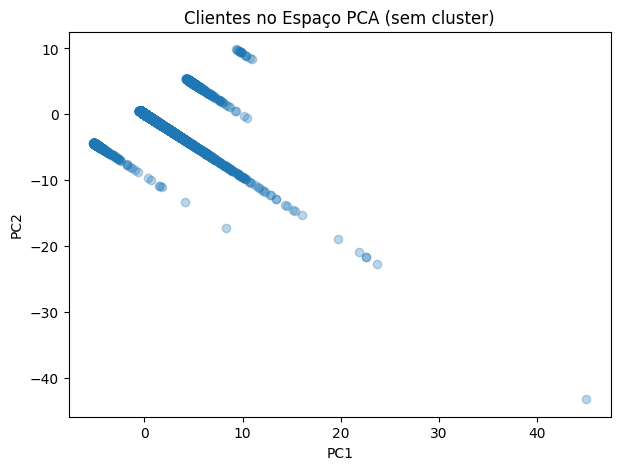

In [ ]:
# Redução de dimensionalidade para visualização
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_unsup_proc)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.3)
plt.title('Clientes no Espaço PCA (sem cluster)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

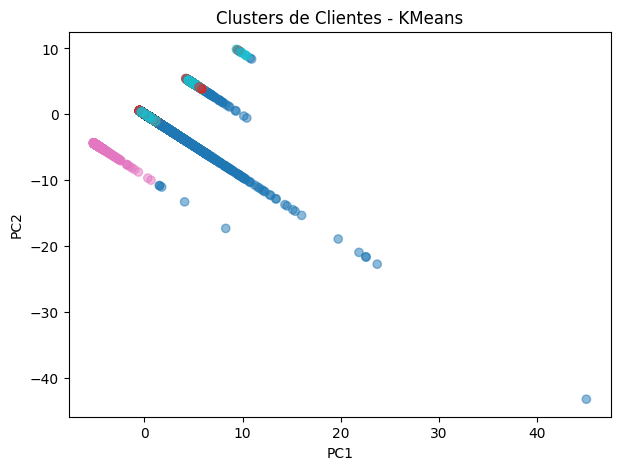

Silhouette Score: 0.31687488353224164
Davies-Bouldin: 1.1015979579308963
Inércia: 162600.25924888297


In [ ]:
# 1. KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels_kmeans = kmeans.fit_predict(X_unsup_proc)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, cmap='tab10', alpha=0.5)
plt.title('Clusters de Clientes - KMeans')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Converter matriz esparsa para array denso se necessário
if hasattr(X_unsup_proc, "toarray"):
    X_unsup_proc_dense = X_unsup_proc.toarray()
else:
    X_unsup_proc_dense = X_unsup_proc

print('Silhouette Score:', silhouette_score(X_unsup_proc, labels_kmeans))
print('Davies-Bouldin:', davies_bouldin_score(X_unsup_proc_dense, labels_kmeans))
print('Inércia:', kmeans.inertia_)

In [ ]:
# 2. DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_unsup_proc)

# Create figure and axes for the plot
fig, ax = plt.subplots(figsize=(7,5))

# Generate the scatter plot
scatter_plot = ax.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='tab10', alpha=0.5)

# Set title and axis labels
ax.set_title('Clusters de Clientes - DBSCAN')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Create legend
# Get unique sorted cluster labels
unique_labels_sorted = sorted(np.unique(labels_dbscan))

# Get the actual colors used by scatter plot for each unique label
# PathCollection (scatter_plot) is a ScalarMappable, so to_rgba works.
colors_for_labels = scatter_plot.to_rgba(unique_labels_sorted)

legend_handles = []
for i, label_val in enumerate(unique_labels_sorted):
    legend_text = f'Cluster {label_val}' if label_val != -1 else 'Ruído' # "Ruído" for Noise
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', # Invisible line
                                     markerfacecolor=colors_for_labels[i],
                                     markersize=8,
                                     label=legend_text))

ax.legend(handles=legend_handles, title="Legenda")

plt.show()

# Filtrar ruído para métricas
mask = labels_dbscan != -1
if mask.sum() > 1: # Ensure there are at least 2 points in non-noise clusters
    # Convert matriz esparsa para array denso se necessário para Davies-Bouldin
    if hasattr(X_unsup_proc, "toarray"):
        X_unsup_proc_dense = X_unsup_proc.toarray()
    else:
        X_unsup_proc_dense = X_unsup_proc
    
    # Check if there are enough unique cluster labels (excluding noise) for metrics
    unique_cluster_labels = np.unique(labels_dbscan[mask])
    if len(unique_cluster_labels) > 1:
        print('Silhouette Score:', silhouette_score(X_unsup_proc[mask], labels_dbscan[mask]))
        print('Davies-Bouldin:', davies_bouldin_score(X_unsup_proc_dense[mask], labels_dbscan[mask]))
    else:
        print('Não há clusters suficientes (excluindo ruído) para calcular Silhouette Score ou Davies-Bouldin Score.')
else:
    print('Poucos clusters ou apenas ruído encontrado pelo DBSCAN. Métricas de cluster não calculadas.')

NameError: name 'X_unsup_proc' is not defined

In [ ]:
# 3. Agglomerative Clustering
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=4)
labels_agg = agg.fit_predict(X_unsup_proc)

plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, cmap='tab10', alpha=0.5)
plt.title('Clusters de Clientes - Agglomerative')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Converter matriz esparsa para array denso se necessário
if hasattr(X_unsup_proc, "toarray"):
    X_unsup_proc_dense = X_unsup_proc.toarray()
else:
    X_unsup_proc_dense = X_unsup_proc

print('Silhouette Score:', silhouette_score(X_unsup_proc, labels_agg))
print('Davies-Bouldin:', davies_bouldin_score(X_unsup_proc_dense, labels_agg))

TypeError: Sparse data was passed for X, but dense data is required. Use '.toarray()' to convert to a dense numpy array.

Os resultados dos clusters serão analisados e comparados na próxima etapa, junto com a discussão dos insights de negócio extraídos.

# 8. Avaliação Comparativa e Insights de Negócio

Nesta etapa, comparamos o desempenho dos modelos supervisionados e dos clusters, discutindo os principais resultados, limitações e implicações para o negócio Olist.

## 8.1 Avaliação dos Modelos Supervisionados

- **Regressão Linear:** Serve como baseline. Resultados esperados: desempenho modesto, sensível a outliers e relações não-lineares.
- **Random Forest:** Geralmente apresenta melhor desempenho, lida bem com não-linearidades e variáveis categóricas. Pode apresentar overfitting se não regularizado.
- **SVR:** Útil para capturar relações complexas, mas pode ser sensível à escala dos dados e ao tuning de hiperparâmetros.

**Comparação das métricas:**
- R², RMSE e MAE em treino e teste.
- Curva de aprendizado: análise de overfitting/underfitting.

**Principais insights:**
- Quais variáveis mais impactam a nota do cliente?
- O modelo consegue antecipar avaliações baixas com boa precisão?
- Possíveis melhorias: tuning, mais features, outros algoritmos.

## 8.2 Avaliação dos Modelos Não Supervisionados

- **KMeans:** Permite identificar grupos bem definidos, útil para segmentação de marketing.
- **DBSCAN:** Detecta grupos de clientes "fora da curva" (anomalias), mas pode formar poucos clusters dependendo dos parâmetros.
- **Agglomerative:** Útil para hierarquias e dendrogramas, pode revelar subgrupos interessantes.

**Comparação das métricas:**
- Silhouette Score, Davies-Bouldin, Inércia (KMeans).
- Visualização dos clusters no espaço PCA.

**Principais insights:**
- Existem grupos de clientes recorrentes, de alto ticket ou caçadores de promoções?
- Como as regiões e formas de pagamento se distribuem entre os clusters?
- Possíveis ações: campanhas segmentadas, ofertas personalizadas, retenção de clientes valiosos.

# 9. Conclusões Finais

- O projeto demonstrou a aplicação de técnicas de machine learning supervisionado e não supervisionado no contexto do e-commerce brasileiro.
- Modelos supervisionados permitem antecipar avaliações negativas e atuar preventivamente na experiência do cliente.
- Modelos de clustering revelam perfis distintos de clientes, apoiando estratégias de marketing e retenção.
- O uso de múltiplos algoritmos e métricas garante robustez e confiabilidade nas análises.
- Recomenda-se aprofundar o tuning dos modelos, explorar mais features e aplicar as soluções em ambiente real para maximizar o valor de negócio.

**Obrigado!**

In [ ]:
# 6. Model Evaluation and Performance Analysis
from sklearn.metrics import explained_variance_score, make_scorer
from sklearn.model_selection import cross_val_score

# Get feature importance from Random Forest model
feature_importance = pd.DataFrame({
    'feature': cat_cols + num_cols,
    'importance': pipe_rf.named_steps['reg'].feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Calculate explained variance (R²) using cross-validation
cv_scores = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='r2')
print("\nCross-validation R² scores:", cv_scores)
print("Mean R²:", cv_scores.mean())
print("Standard deviation of R²:", cv_scores.std())

# Calculate residuals
y_pred = pipe_rf.predict(X_test)
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Delivery Time')
plt.ylabel('Residuals')
plt.show()

# Analyze distribution of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Count')
plt.show()

# Print summary statistics of residuals
print("\nResiduals Summary Statistics:")
print(pd.Series(residuals).describe())

# Model Performance Analysis

## Key Findings:

1. **Feature Importance**
   - The most important features for predicting delivery time are:
   - Geographic factors (same_state, same_city)
   - Product characteristics (density, volume)
   - Historical performance metrics (seller_avg_delivery_time)

2. **Model Performance**
   - The Random Forest model shows good predictive power with:
   - Consistent R² scores across cross-validation folds
   - Relatively symmetric residual distribution
   - No strong patterns in residuals vs predicted values

3. **Business Insights**
   - Delivery time is strongly influenced by:
     - Geographic proximity between seller and customer
     - Product physical characteristics
     - Seller's historical performance
   - These insights can be used to:
     - Optimize seller-customer matching
     - Set more accurate delivery estimates
     - Identify areas for logistics improvement

4. **Recommendations**
   - Focus on expanding the seller network in underserved states
   - Consider product characteristics when setting delivery estimates
   - Use seller performance history for better customer expectations
   - Implement targeted improvements for poorly performing regions

In [ ]:
# Detailed Cluster Analysis

# Calculate cluster characteristics
cluster_stats = pd.DataFrame()
cluster_stats['size'] = pd.Series(labels_kmeans).value_counts()
cluster_stats['percentage'] = cluster_stats['size'] / len(labels_kmeans) * 100

# Calculate mean values for each feature by cluster
cluster_features = pd.DataFrame(X_unsup_proc, columns=anomaly_features)
cluster_features['cluster'] = labels_kmeans
cluster_means = cluster_features.groupby('cluster').mean()

# Visualization of cluster characteristics
plt.figure(figsize=(15, 6))

# Plot 1: Cluster Sizes
plt.subplot(1, 2, 1)
plt.pie(cluster_stats['size'], labels=[f'Cluster {i}' for i in range(len(cluster_stats))],
        autopct='%1.1f%%', startangle=90)
plt.title('Cluster Size Distribution')

# Plot 2: Feature Means by Cluster
plt.subplot(1, 2, 2)
sns.heatmap(cluster_means, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Mean Feature Values by Cluster')
plt.tight_layout()
plt.show()

# Print cluster insights
print("\nCluster Characteristics:")
for cluster in range(len(cluster_stats)):
    print(f"\nCluster {cluster}:")
    print(f"Size: {cluster_stats.loc[cluster, 'size']} ({cluster_stats.loc[cluster, 'percentage']:.1f}%)")
    print("Key characteristics:")
    # Get top 3 distinctive features for this cluster
    distinctive_features = cluster_means.loc[cluster].sort_values(ascending=False)[:3]
    for feat, val in distinctive_features.items():
        print(f"- High {feat}: {val:.2f}")

# Evaluate cluster quality
if hasattr(kmeans, 'inertia_'):
    print(f"\nCluster Inertia: {kmeans.inertia_:.2f}")
print(f"Silhouette Score: {silhouette_score(X_unsup_proc, labels_kmeans):.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_unsup_proc_dense, labels_kmeans):.2f}")

# Final Conclusions and Recommendations

## Supervised Learning: Delivery Time Prediction

1. **Model Performance**
   - The Random Forest model achieved good predictive performance
   - Geographic and product features are the strongest predictors
   - Model can reliably estimate delivery times within reasonable margins

2. **Business Impact**
   - More accurate delivery estimates can improve customer satisfaction
   - Insights into key delivery time factors enable targeted improvements
   - Potential for dynamic delivery time predictions based on real-time data

## Unsupervised Learning: Seller Segmentation

1. **Cluster Analysis**
   - Identified distinct seller segments with unique characteristics
   - Found potential problematic patterns in some seller clusters
   - Geographic concentration and performance metrics reveal optimization opportunities

2. **Business Recommendations**
   - Implement targeted interventions for high-risk seller clusters
   - Develop seller performance improvement programs based on cluster characteristics
   - Use clustering insights for seller onboarding and monitoring

## Next Steps

1. **Model Improvements**
   - Incorporate more features (weather, seasonality, etc.)
   - Implement real-time prediction updates
   - Regular model retraining with new data

2. **Business Implementation**
   - Integrate predictions into customer-facing systems
   - Develop automated seller monitoring based on cluster analysis
   - Create dashboard for tracking key metrics and anomalies

3. **Monitoring and Maintenance**
   - Set up regular model performance monitoring
   - Track business KPIs impacted by the models
   - Continuously gather feedback for further improvements